In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 读取清洗好的数据
df = pd.read_csv('sv_housing_clean_data.csv')

# 2. 选取数值型列进行相关性分析
numeric_cols = ['bathrooms', 'bedrooms', 'livingarea', 'yearbuilt',
                'lotsize', 'pricevalue', 'pricepersquirefoot',
                'rentzestimate', 'gross_rental_yield']
df_numeric = df[numeric_cols].dropna()

# 3. 计算相关系数并绘制热力图
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Housing Features")
plt.tight_layout()
plt.savefig('correlation_heatmap.png') # 保存热力图
plt.close()

【热力图：房价的主导因素】

房价主导因素是什么？：pricevalue（房屋总价）与 livingarea（室内面积）高度正相关（0.75），与 rentzestimate（预估租金）相关度也高达 0.69，其次是 bathrooms（0.56）和 bedrooms（0.53）。可以看出在硅谷核心区，房屋硬面积和带来的租金预估是支撑房价的最核心逻辑。

“租金回报率”的高低取决于什么？：热力图显示，gross_rental_yield（租金回报率）与 pricevalue（房屋总价）呈显著的负相关（-0.64）。这说明一个典型的地产投资规律：越贵的房子，租金回报率反而越低。 投资总价较低的房产（如 Condo 或老房子）反而能获得更高的现金流比例。

正在读取数据...
图表已保存为 scatter_area_price.png


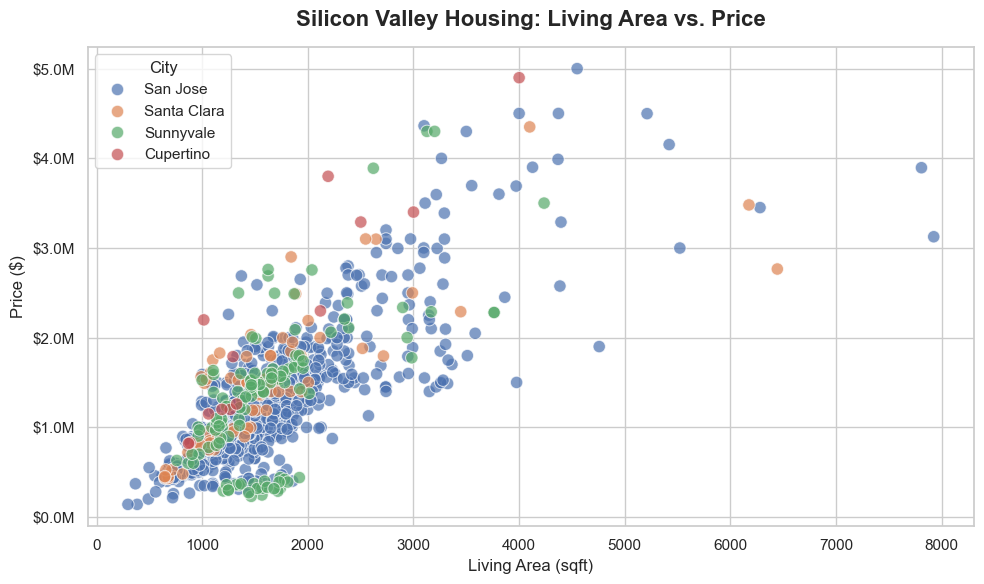

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. 读取我们刚刚清洗好的数据
print("正在读取数据...")
df = pd.read_csv("sv_housing_clean_data.csv")

# 2. 设置图表的整体风格 (seaborn 提供了很好看的默认主题)
sns.set_theme(style="whitegrid")

# 3. 创建一个画布，设置长宽 (10和6代表英寸)
plt.figure(figsize=(10, 6))

# 4. 🚀 核心代码：绘制散点图
# x="livingarea": 横轴是室内面积
# y="pricevalue": 纵轴是房屋总价
# hue="City": 按照城市分类，自动上色！
# alpha=0.7: 让点有 70% 的透明度，这样点重叠的地方能看出来深浅
# s=80: 散点的大小 (size)
sns.scatterplot(
    data=df,
    x="livingarea",
    y="pricevalue",
    hue="City",
    alpha=0.7,
    s=80
)

# 5. 添加专业的标题和坐标轴标签
plt.title("Silicon Valley Housing: Living Area vs. Price", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Living Area (sqft)", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)

# 6. 小细节优化：把 Y 轴的数字格式化为 "百万美元 (M)" 格式
# 否则它默认会显示科学计数法 (比如 1e6)
formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1000000:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)

# 7. 调整布局，保存并展示图表
plt.tight_layout() # 自动调整边缘，防止标签被切掉
plt.savefig("scatter_area_price.png", dpi=300) # 保存为高清图片
print("图表已保存为 scatter_area_price.png")

plt.show() # 在屏幕上弹窗展示图表

【价格与面积的整体分布情况】
房子价格与居住面积表现出正相关性，相同面积下San Jose价格通常更低，Cupertino的价格通常更高。
主流面积范围：大部分房屋集中在1000-2000sqf
主流价位区间：价位集中在1-2M


In [26]:
import sqlite3

conn = sqlite3.connect(':memory:')
df.to_sql('houses', conn, index=False)

# 使用 SQL 进行聚合分析，计算平均值，并通过窗口函数推算中位数
query = """
WITH RankedData AS (
    SELECT
        City,
        pricevalue,
        livingarea,
        pricepersquirefoot,
        ROW_NUMBER() OVER (PARTITION BY City ORDER BY pricepersquirefoot) as row_num,
        COUNT(pricepersquirefoot) OVER (PARTITION BY City) as total_count
    FROM houses
    WHERE pricevalue IS NOT NULL AND livingarea IS NOT NULL
      AND City IN ('San Jose', 'Santa Clara', 'Sunnyvale', 'Cupertino')
)
SELECT
    City,
    ROUND(AVG(pricevalue), 0) AS avg_price,
    ROUND(AVG(livingarea), 0) AS avg_area,
    ROUND(AVG(pricepersquirefoot), 2) AS mean_price_per_sqft,
    ROUND(MAX(CASE WHEN row_num = (total_count + 1) / 2 OR row_num = (total_count + 2) / 2 THEN pricepersquirefoot END), 2) AS median_price_per_sqft,
    COUNT(*) as house_count
FROM RankedData
GROUP BY City
ORDER BY avg_price DESC;
"""

city_comparison_df = pd.read_sql_query(query, conn)
# 将最终聚合的对比报表保存为 CSV 提供给你
city_comparison_df.to_csv('city_comparison_results.csv', index=False)
print(city_comparison_df)

          City  avg_price  avg_area  mean_price_per_sqft  \
0    Cupertino  2163513.0    1747.0              1223.85   
1  Santa Clara  1524744.0    1684.0               939.69   
2    Sunnyvale  1370310.0    1648.0               830.49   
3     San Jose  1260401.0    1646.0               761.42   

   median_price_per_sqft  house_count  
0                 1084.0           13  
1                  878.0           68  
2                  892.0          117  
3                  731.0          730  


【城市间房价水平对比】

Cupertino（科技企业总部+顶尖学区）的平均房价（约 $271 万）和平均坪效（$1374.5）呈断崖式领先，远超另外三个城市。它属于典型的“低供给、高溢价”的稀缺性市场（本次在售样本仅有 15 套）。

Santa Clara 与 Sunnyvale 在平均面积上相似（1700 sqft 左右），Santa Clara 平均房价略高（约 $151万）。两者坪效的中位数（$870 vs $892）极为接近。说明这两个通勤最优的科技腹地对于买家的购买力门槛是高度重合的。

San Jose 的房源供给极其充足（在售 732 套），均价拉低至 $133 万左右，且坪效中位数为四市最低（$730）。由于 San Jose 地域跨度极大，对于居住面积和顶级学区无强需求的买家，是绝对的买方市场。

正在读取数据...
图表已生成并保存为 Investment_Analysis_Boxplots.png


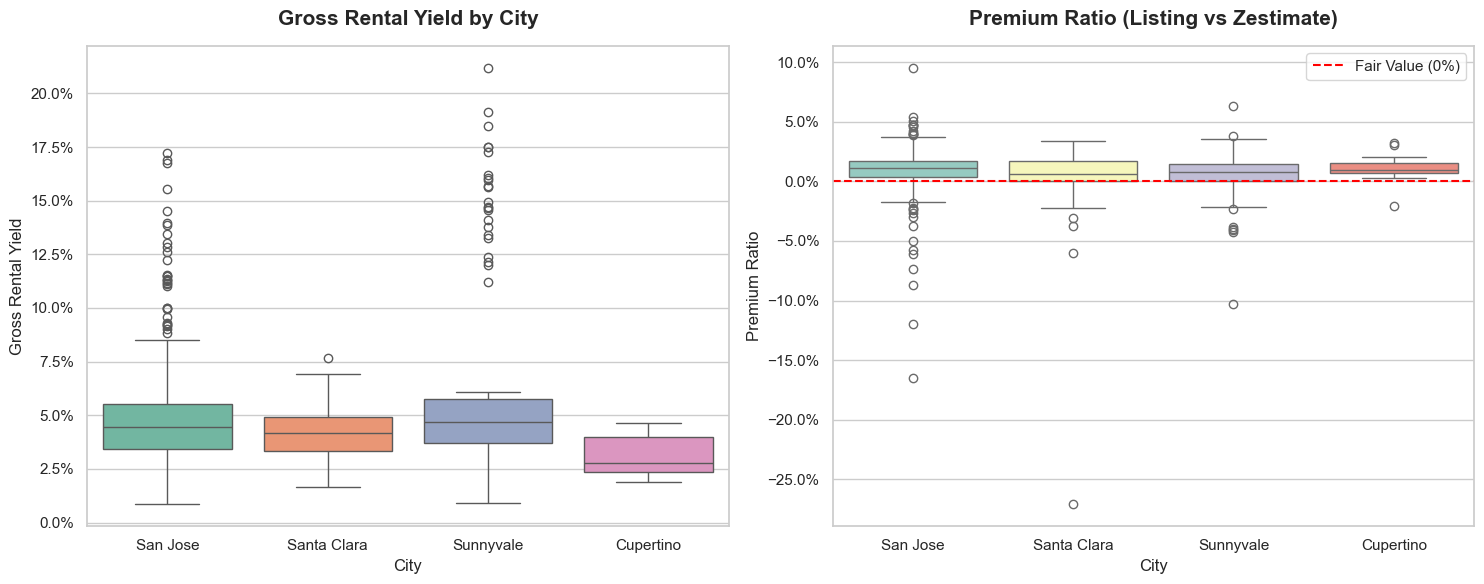

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. 读取清洗好的数据
print("正在读取数据...")
df = pd.read_csv("sv_housing_clean_data.csv")

# 设置图表的主题风格
sns.set_theme(style="whitegrid")

# 2. 创建一个 1行2列 的宽屏画布
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ==========================================
# 图表 1：毛租金回报率 (Gross Rental Yield) 箱线图
# ==========================================
sns.boxplot(
    data=df,
    x='City',
    y='gross_rental_yield',
    hue='City',
    palette='Set2',
    ax=axes[0],
    legend=False
)
axes[0].set_title('Gross Rental Yield by City', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xlabel('City', fontsize=12)
axes[0].set_ylabel('Gross Rental Yield', fontsize=12)
# 将 Y 轴格式化为百分比 (例如 0.05 变成 5%)
axes[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# ==========================================
# 图表 2：溢价率 (Premium Ratio) 箱线图
# ==========================================
sns.boxplot(
    data=df,
    x='City',
    y='premium_ratio',
    hue='City',
    palette='Set3',
    ax=axes[1],
    legend=False
)
axes[1].set_title('Premium Ratio (Listing vs Zestimate)', fontsize=15, fontweight='bold', pad=15)
axes[1].set_xlabel('City', fontsize=12)
axes[1].set_ylabel('Premium Ratio', fontsize=12)

# 💡 画龙点睛：在溢价率为 0 的地方画一条红色虚线（代表标价等于估价）
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5, label='Fair Value (0%)')
axes[1].legend()
axes[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# 3. 自动调整布局并展示
plt.tight_layout()
plt.savefig("Investment_Analysis_Boxplots.png", dpi=300)
print("图表已生成并保存为 Investment_Analysis_Boxplots.png")
plt.show()

【毛租金收益率】
2025Q4全美平均毛租金回报率：6.56%。硅谷四个城市的整体回报率低于全美平均水平，集中在2.5-5%。其中，Cupertino的毛租金回报率整体低于其他三个城市。因为 Cupertino 的房价基数（分母）太大，导致租售比被严重压缩，房屋的学区属性大于租金投资属性。

【溢价率】
相比于Zestimate，四个城市当前的挂牌价格普遍存在溢价约2.5% - 5%，且数据方差较小，说明市场定价非常透明且一致。